In [1]:
# eton@241219 convert301PACS_formart
import json
import os
import numpy
import pathlib

j_target_s="""
{
  "shapes": [
    {
      "label": "\u9888\u52a8\u8109:CA",
      "line_color": null,
      "fill_color": null,
      "points": [
        [
          296,
          253
        ],
        [
          295,
          373
        ],
        [
          430,
          363
        ],
        [
          427,
          255
        ]
      ]
    }
  ],
  "lineColor": [
    0,
    255,
    0,
    128
  ],
  "fillColor": [
    255,
    0,
    0,
    128
  ],
  "imagePath": "frm-0001.png",
  "imageData": null
}
"""

j_target_o = json.loads(j_target_s)
j_shape_item = j_target_o["shapes"][0].copy()
j_shape_item["points"].clear()
j_shape_item["label"]=str()

#print(j_shape_item,j_shape_item)

def convert_nodule_json_v2(json_file, target_json_dir):
    """
        deal with one xiaobai's json which have multi-labelme json
        - if points less than 4, ignore it. --eton@241202
    """

    if not os.path.exists(target_json_dir):
        print(f"json target directory not exist.")
        return -1
    # 01-read from nodule-json-file
    with open(json_file, 'r') as f:
        json_ = json.load(f)
        all_imgs_datas = json_['data']
        one_data_item = all_imgs_datas[0]

        if False:#debug
            print("json has item number=", len(json_))
            for i in json_:
                print(f"\titem[{i}]")
            print("total has data number=", len(all_imgs_datas), type(all_imgs_datas))
            print(type(all_imgs_datas[0]))

            print(f"\titems in \\data\\")
            for i in one_data_item:
                print(f"\t\t{i}")
            #print(f"\t\t lesions in data.")
            print("\t\t one_data_item['frameNumber']:", one_data_item['frameNumber'])

        ## extract infomation --all images.
        for one_data_item in all_imgs_datas:
            frameNumber = one_data_item['frameNumber']
            #--02 extract json per image
            polygonPoints=[]
            filename = f"frm-{(frameNumber+1):04d}"
            #--02.1 remove the exist json file
            target_json_name = os.path.join(target_json_dir, f"{filename}.json")
            if os.path.exists(target_json_name):
                os.remove(target_json_name)
                #print(f">>>>>delete file{target_json_name}")

            #--03 create target labelme format json
            target_json=j_target_o.copy()
            target_json['imagePath']=f"{filename}.png"
            target_json['shapes'].clear()

            lesions = one_data_item["lesions"]
            isCurrentImageHasLabelmeJsonFile=False
            if(len(lesions)>0):
                for lesion_idx in range(len(lesions)):
                    polygonPoints=lesions[lesion_idx]["polygonPoint"]

                    points_len = int((len(polygonPoints)))
                    if points_len < 4:
                        print(f"\tpoints not enough 4:[{target_json_dir}/{filename}], ignore it.")
                        continue

                    all_points = numpy.zeros((points_len, 2))
                    all_points = polygonPoints
                    #--03.2 delete zeros
                    available_pts = []
                    for pt in range(points_len):
                        #print(f"point [{pt}]={all_points[pt]}")
                        if all_points[pt][0] is None or all_points[pt][0]<10:
                            #print(f"point[{pt}] is {all_points[pt]} delete it...")
                            continue
                        else:
                            available_pts.append(all_points[pt])

                    if len(available_pts) < 4:
                        print(f"\tavailable points not enough 4:[{target_json_dir}/{filename}], ignore it.")
                        continue
                    #--04 create target labelme format json
                    #if lesion_idx>0:
                    target_json["shapes"].append(j_shape_item.copy())

                    target_json['shapes'][lesion_idx]['label']='ThyNodu'
                    target_json['shapes'][lesion_idx]['points']=available_pts
                    isCurrentImageHasLabelmeJsonFile=True
            else:
                target_json['shapes'].clear()

            if False == isCurrentImageHasLabelmeJsonFile:
                continue

            #--05 write to disk
            target_json_name = os.path.join(target_json_dir, f"{filename}.json")

            if os.path.exists(target_json_name):
                os.remove(target_json_name)
                #print(f">>>>>delete file{target_json_name}")
            with open(target_json_name, 'w') as jfp:
                json.dump(target_json, jfp)
    print(f"\t<<<one case done.")

    return 0

#==========

def list_folders(directory):
    try:
        folders = []
        with os.scandir(directory) as it:
            for entry in it:
                if entry.is_dir():
                    folders.append(entry.name)
        return folders
    except Exception as e:
        print(f"Error: {e}")
        return []

def list_folders(directory):
    try:
        # List all entries in the directory
        entries = os.listdir(directory)
        # Filter out only the directories
        folders = [entry for entry in entries if os.path.isdir(os.path.join(directory, entry))]
        return folders
    except Exception as e:
        print(f"Error: {e}")
        return []

def list_File_withSuffix(directory, suffix:str="_MARK.json"):
    try:
        # List all entries in the directory
        entries = os.listdir(directory)
        # Filter out only the directories
        folders = [entry for entry in entries if entry.endswith(suffix)]
        return folders
    except Exception as e:
        print(f"Error: {e}")
        return []

def processMultiFolders(working_dir:str):
    casefolders = list_folders(working_dir)
    totalCaseCount=len(casefolders)
    #caseindex=0

    for caseindex, icase in  enumerate(casefolders):
        print(f"[{caseindex}/{totalCaseCount}] : processing... {icase}")
        icasedir=os.path.join(working_dir, icase)
        foldersInCase=list_folders(icasedir)
        jsonInCase=list_File_withSuffix(icasedir)
        #print(foldersInCase, jsonInCase)

        if(len(jsonInCase)<1 or len(foldersInCase)<1):
            print(f"caseDir:[{icasedir}] missing json/dicom-img-folder, ignore....")
            continue
        json_file_name = os.path.join(icasedir, jsonInCase[0])
        dcm_folder_name = os.path.join(icasedir, foldersInCase[0])

        failed = convert_nodule_json_v2(json_file_name, dcm_folder_name)
        if 0 != failed:
            print(f"\tconvert failed!!!")
        else:
            print("success,,,")

def testOnSingleJson():
    jsonf=r'/mnt/f/240926-RayShap/241129-thyroid-datas/52-debug/thyroidNodules_axp087/1.2.250.1.204.5.8373724313.20210416143848345628.2.0.50.80.2.20241111095056666_MARK.json'
    targetHome=r'/mnt/f/240926-RayShap/241129-thyroid-datas/52-debug/thyroidNodules_axp087/targetJsonLabelformatDir'
    convert_nodule_json_v2(jsonf, targetHome) 


if "__main__" == __name__:
    working_dir=r"/mnt/f/240926-RayShap/241129-thyroid-datas/52-debug"
    processMultiFolders(working_dir)

Error: [Errno 2] No such file or directory: '/mnt/f/240926-RayShap/241129-thyroid-datas/52-debug'


In [157]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

colorRed=(255,0,0)
colorGreen=(0,255,0)
colorBlue=(0,0,255)

def find_pointsOnOrthogonalLineByDistance_notwork01(point1, point2, distance):
    """
    Find the two points that are equidistant from the midpoint of the line.

    Parameters:
    point1 (tuple): The coordinates of the first point (x1, y1).
    point2 (tuple): The coordinates of the second point (x2, y2).
    distance (float): The distance from the midpoint to each of the new points.

    Returns:
    tuple: The coordinates of the two new points (new_point1, new_point2).
    """
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the midpoint of the line
    mid_x = (x1 + x2) / 2
    mid_y = (y1 + y2) / 2

    # Calculate the direction vector
    dx = x2 - x1
    dy = y2 - y1
    length = math.sqrt(dx * dx + dy * dy)
    dir_x = dx / length
    dir_y = dy / length

    # Calculate the new points
    new_point1 = (mid_x + distance * dir_x, mid_y + distance * dir_y)
    new_point2 = (mid_x - distance * dir_x, mid_y - distance * dir_y)
    int_tuple1 = tuple(int(item) for item in new_point1)
    int_tuple2 = tuple(int(item) for item in new_point2)

    return (int_tuple1, int_tuple2)

def find_pointsOnOrthogonalLineByDistance(point1, point2, outLen):
    """
    Calculate a line orthogonal to the given line, with a specified length, intersecting at the center.

    Parameters:
    point1 (tuple): The coordinates of the first point of lineA (x1, y1).
    point2 (tuple): The coordinates of the second point of lineA (x2, y2).
    outLen (float): The desired length of lineB.

    Returns:
    tuple: The coordinates of the two points of lineB (new_point1, new_point2).
    """
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the midpoint of lineA
    mid_x = (x1 + x2) / 2
    mid_y = (y1 + y2) / 2

    # Calculate the direction vector of lineA
    dx = x2 - x1
    dy = y2 - y1
    length = math.sqrt(dx * dx + dy * dy)

    # Calculate the orthogonal direction vector
    ortho_dx = -dy / length
    ortho_dy = dx / length

    # Calculate the endpoints of lineB
    half_length = outLen / 2
    new_point1 = (mid_x + half_length * ortho_dx, mid_y + half_length * ortho_dy)
    new_point2 = (mid_x - half_length * ortho_dx, mid_y - half_length * ortho_dy)

    int_tuple1 = tuple(int(item) for item in new_point1)
    int_tuple2 = tuple(int(item) for item in new_point2)

    return (int_tuple1, int_tuple2)

def processOnlyHasTwoPoints(img:np.ndarray, point1:tuple, point2:tuple):
     # Draw a diagonal blue line with thickness of 5 px
    oneLine=(point1, point2)
    # Calculate the center of the circle/ellipse
    center_x = (point1[0] + point2[0]) // 2
    center_y = (point1[1] + point2[1]) // 2
    centerxy = (center_x, center_y)
    
    # Calculate the radius of the circle
    radius = int(np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) / 2)
    
    cv2.line(img,point1, point2, colorRed, 1)
    # Draw the circle
    cv2.circle(img, centerxy, radius, colorGreen, 1)
    
    #plt.imshow(img)
    return img

def rotatedRectangleDefinedEllipseToPolygon(rrEllipse:tuple):
    rotatedRect_Center, rotatedRect_size, rotatedRect_angle = rrEllipse
    
    # Define a lambda function to convert float to int
    # Use the lambda function with map to convert the tuple
    convert_to_int = lambda float_tuple: tuple(map(int, float_tuple))
    #print(f"rotatedRect_Center type={type(rotatedRect_Center)}, {rotatedRect_Center}, rotatedRect_size={rotatedRect_size}")
    
    rotatedRect_Center = convert_to_int( rotatedRect_Center)
    rotatedRect_size = convert_to_int( rotatedRect_size)
    rotatedRect_angle = int(rotatedRect_angle)

    # Calculate the axes of the ellipse
    axes = (int(rotatedRect_size[0] / 2), int(rotatedRect_size[1] / 2))

    #print(f"rotatedRect_Center type={type(rotatedRect_Center)}, {rotatedRect_Center}, rotatedRect_size={rotatedRect_size}")

    delta4Angle=30
    ellipse_points = cv2.ellipse2Poly(rotatedRect_Center, axes, rotatedRect_angle, 0, 360, delta4Angle)
    # Convert the points to a polygon
    polygon = np.array(ellipse_points, dtype=np.int32) #shape=(n, 2)
    list_of_tuples = [tuple(row) for row in polygon.tolist()]
    print(f"debug: polygon.shape={polygon.shape},list_of_tuples={list_of_tuples} ")
    #polygon = polygon.reshape((-1, 1, 2))

    return list_of_tuples

def processOneLineAndALength(img:np.ndarray, point1:tuple, point2:tuple, anotherAxisLen:float):
    print(f"debug: point1-2={point1}, {point2}, AxisLen={anotherAxisLen}")
    cv2.line(img,point1, point2, colorRed, 1)
    
    orthoPts = find_pointsOnOrthogonalLineByDistance(point1, point2, anotherAxisLen)
    print(f"debug: orthoPts={orthoPts}")
    cv2.line(img,orthoPts[0], orthoPts[1], colorRed, 1)
    line1=[point1, point2]
    line2=[orthoPts[0], orthoPts[1]]
    ellipse = fit_ellipse_to_lines(line1, line2)
    cv2.ellipse(img, ellipse, (0, 255, 0), 2)

    polygon_list_of_tuples = rotatedRectangleDefinedEllipseToPolygon(ellipse)

    
    polygon = polygon_list_of_tuples
    print(f"debug:polygon type={type(polygon)}, len= {len(polygon)}, values[0]={polygon[0]}")
    if type(polygon_list_of_tuples) is not np.ndarray:
         polygon = np.array(polygon_list_of_tuples) #(list_of_tuples)to ndarray
    print(f"debug:polygon type={type(polygon)}, shape={polygon.shape}, len= {len(polygon)}, values[0]={polygon[0]}")

    polygon = polygon.astype(np.int32)
    cv2.polylines(img, [polygon], isClosed=True, color=(0, 255, 120), thickness=1)
    

    #plt.imshow(img)
    return (img, polygon_list_of_tuples)

# Function to find the intersection of two line segments
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return int(x), int(y)
    
def fit_ellipse_to_lines(line1, line2):
    print(f"debug: line1={line1}")
    intersection = line_intersection(line1, line2)
    if intersection is None:
        raise ValueError("Lines do not intersect")

    points = np.array([
        [line1[0][0], line1[0][1]],
        [line1[1][0], line1[1][1]],
        [line2[0][0], line2[0][1]],
        [line2[1][0], line2[1][1]],
        intersection
    ], dtype=np.float32)

    # Fit an ellipse to the points
    ellipse = cv2.fitEllipse(points)
    return ellipse

def processHasFourPoints(img:np.ndarray,line1:list, line2:list):
    # Find the intersection point
    intersection = line_intersection(line1, line2)
    
    # Calculate distances from the intersection point to each of the four points
    distances = [
        np.sqrt((intersection[0] - line1[0][0])**2 + (intersection[1] - line1[0][1])**2),
        np.sqrt((intersection[0] - line1[1][0])**2 + (intersection[1] - line1[1][1])**2),
        np.sqrt((intersection[0] - line2[0][0])**2 + (intersection[1] - line2[0][1])**2),
        np.sqrt((intersection[0] - line2[1][0])**2 + (intersection[1] - line2[1][1])**2)
    ]
    
    # Determine the major and minor axes
    major_axis = max(distances)
    if distances.index(major_axis) <2:
        distances=distances[2:]
    else:
        distances=distances[:2]
    minor_axis = max(distances)
    
    # Ensure the ellipse is within the image boundaries
    center_x, center_y = intersection
    major_axis = int(major_axis)
    minor_axis = int(minor_axis)
    
    # Adjust the center and axes if necessary
    if center_x - major_axis < 0:
        major_axis = center_x
    if center_x + major_axis >= image_width:
        major_axis = image_width - center_x - 1
    if center_y - minor_axis < 0:
        minor_axis = center_y
    if center_y + minor_axis >= image_height:
        minor_axis = image_height - center_y - 1
    
    # Draw the line segments
    cv2.line(img, line1[0], line1[1], colorGreen, 1)
    cv2.line(img, line2[0], line2[1], colorGreen, 1)
    
    # Draw the ellipse
    cv2.ellipse(img, intersection, (major_axis, minor_axis), 0, 0, 360, colorGreen, 1)
    
    # Display the image
    #plt.imshow(img)
    return img

def savefile0002():
    imgPath=Path(self.m_imgname)
    pathstem=imgPath.stem
    newName=pathstem+"_crop"
    newimgname=self.m_imgname.replace(pathstem, newName)
    #logger.info(f"debug:cropped_image.shape={cropped_image.shape}, newName={newimgname}")
    cv2.imwrite(newimgname, img)

In [158]:
#the files struct as follow
# eton@241221 update for one case as 3d; oneline is ellipse which take axis from two lines image;
# eton@241222 make it aviilable from PACS format to labelme foramt;
"""
./02.202401010411.01$ ls -l
total 208
-rwxrwxrwx 1 bibao bibao  98435 Dec 10 11:58 02.202401010411.01.20173.0001.14273100603_crop.jpg
-rwxrwxrwx 1 bibao bibao 102899 Dec 10 11:58 02.202401010411.01.20173.0002.14275200432_crop.jpg
-rwxrwxrwx 1 bibao bibao    741 Dec 13 09:34 02.202401010411.01_pre.json
"""
import shutil
import math    
import cv2
import matplotlib.pyplot as plt
import json

from multimethod import multimethod
#casepath=pathlib.Path(casefolder)

target_json_str="""
{
	"shapes": [
		{
			"label": "ThyNodu",
			"line_color": null,
			"fill_color": null,
			"points": [
				[
					234.07785113437782,
					325.2085282340851
				]
			]
		}
	],
	"lineColor": [
		0,
		255,
		0,
		128
	],
	"fillColor": [
		255,
		0,
		0,
		128
	],
	"imagePath": "frm-0149.png",
	"imageData": null
}
"""

class Converter_301PACS:
    def __init__(self, casepath:pathlib.Path, imgfile:str=''):
        self.m_casePath=casepath
        self.m_imgname = imgfile
        self.m_imgCount = 0
        self.m_percentage=0.3
        self.m_oriImage=None

    def getImgAndJsonfileName(self):
        self.m_imgCount +=1
        imgNum = self.m_imgCount
        newImgName=f"frm-{imgNum:04}.png"
        newJsonName=f"frm-{imgNum:04}.json"
        return (newImgName, newJsonName)
        
    def applyImageResult2fileOrVisual(self, img:np.ndarray, useOriginImgName=False, newimgname:str=''):
        if len(newimgname) < 2:
            print(f"Err: newimgName not legal!")
            return -1
        if False == useOriginImgName:
            imgPath=pathlib.Path(newimgname)
            pathstem=imgPath.stem
            newName=pathstem+"_crop"
            newimgname=self.m_imgname.replace(pathstem, newName)
        #logger.info(f"debug:cropped_image.shape={cropped_image.shape}, newName={newimgname}")
        cv2.imwrite(newimgname, img)

    def saveConvertedPairToFile(self, imagepath:pathlib.Path, polygonShape:list, targetFolder:pathlib.Path):
        """
        save the image and json to  target. image copy from origin folder, json will assembled here.
        """
        if not imagepath.is_file():
            print(f"Err: image not exist:{imagepath}")
            return -1
            
        newImgName,newJsonName =self.getImgAndJsonfileName()
        newImagePath = targetFolder.joinpath(newImgName)
        newJsonPath = targetFolder.joinpath(newJsonName)
        
        targetFolder.mkdir(parents=True, exist_ok=True)
        shutil.copy(imagepath, newImagePath)
    
        print(f"debug: newImg path={newImagePath}, {newJsonPath}, polygonShape[0]={type(polygonShape[0])}")
        
        j_target_o = json.loads(target_json_str)
        j_shape_item = j_target_o["shapes"][0].copy()
        j_shape_item["points"].clear()


         #--03 create target labelme format json
        target_json=j_target_o.copy()
        target_json['imagePath']=newImgName
        target_json['shapes'].clear()
        
        j_shape_item["points"]= polygonShape# [(33,44)]#polygonShape
        target_json['shapes'].append(j_shape_item)
        
        #--05 write to disk file
        if newJsonPath.is_file():
            newJsonPath.unlink()
        with open(newJsonPath, 'w') as jfp:
            json.dump(target_json, jfp)
        return 0

class CaseInfoStruct:
    def __init__():
        self.point=tuple()
        self.line=[tuple(). tuple()]
        
def getPath4AfterConverted(casepath:pathlib.Path):
    pathParent = casepath.parent
    caseName=casepath.stem
    substring=".20"
    if substring in caseName:
        caseName=caseName.replace(substring, "-")
    caseName=f"301PACS{caseName}"
    labelmeFmtfoler=pathParent.joinpath(caseName)

    return labelmeFmtfoler


@multimethod
def line_length2(point1, point2):
    """
    Calculate the length of a line segment defined by two points.

    Parameters:
    point1 (tuple): The coordinates of the first point (x1, y1).
    point2 (tuple): The coordinates of the second point (x2, y2).

    Returns:
    float: The length of the line segment.
    """
    x1, y1 = point1
    x2, y2 = point2
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx * dx + dy * dy)
    
@multimethod
def line_length(lineSeg):
    pt1, pt2 = lineSeg
    print(f"lineSeg:{lineSeg}, pt1={pt1}")
    return line_length2(pt1, pt2)

def islineInVertical(measLine):
    oneLineVertical = True
    pt1 = measLine[0]
    pt2 = measLine[1]

    deltaX=abs(pt1[0]-pt2[0])
    deltaY=abs(pt1[1]-pt2[1])
    if deltaX > deltaY:
        oneLineVertical = False #horizon

    return oneLineVertical


def parseJsonInPACSfolder(jsonPath:pathlib.Path, imagefileslist:list):
    """
    parse the json file in case folder, assume there is only one json, which include all images and measures information;
    input: json path
    output: tupe(return code, parsed info)
    
    - eton@241222;
    """
    if not jsonPath.is_file():
        print(f"Error: json file[{jsonPath}] not exist.")
        return (-1, None)
    
    with open(jsonPath, 'r') as fp:
        jsobj=json.load(fp)

    itemCntInJson=len(jsobj)
    imgsCnt=len(imagefileslist)
    if itemCntInJson != imgsCnt:
        print(f"WARNING: json has {itemCntInJson} items, but images count is {imgsCnt}.!!!")
    
    curCaseMeasType=0 #one image has a area defined by two intersection lines and one image has one line segment in 3rd dimension;
    twoIntersectionLines=[]
    oneLineSegments=[]
    allimgMeasPairs=[]  # parse json from files;
    for iitem in jsobj: ##01- get info from origin files;
        #print(f"iitem={iitem}")
        bindImgName=iitem["name"]
        measurePoints=iitem["points"]
        print(f"debug: bindImgName={bindImgName} ,  measurePoints={measurePoints}")
        pointTupleList=[]
        for measPt in measurePoints:
            pointTupleList.append((measPt['x'], measPt['y']))
        bindImgPath=jsonPath.parent.joinpath(bindImgName)
        imgMeasPair = None

        if 2 == len(pointTupleList):
            point1=pointTupleList[-1]
            point2=pointTupleList[-2]
            oneLineSegments=[point1, point2]
            imgMeasPair=(bindImgPath, oneLineSegments)
        elif 4 == len(pointTupleList):
            twolines=[]
            for idx in range(0, 4, 2):
                point1=pointTupleList[idx]
                point2=pointTupleList[idx+1]
                twolines.append(point1)
                twolines.append(point2)

            line1=twolines[0:2]
            line2=twolines[2:]
            twoIntersectionLines=[line1, line2]
            #imgMeasPair=(bindImgPath, twoIntersectionLines) # lineSegment as item unit
            #make all item is points
            imgMeasPair=(bindImgPath, twolines)  # points as item unit
            
        if type(imgMeasPair) is tuple:
            allimgMeasPairs.append(imgMeasPair)
    return [0, allimgMeasPairs]
    

@multimethod
def processOnePACSfolder(casepath:pathlib.Path):
    if  not casepath.is_dir():
        print(f"not exist dir:{casepath}")
        return -1
        
    labelmefolderpath=getPath4AfterConverted(casepath)
    
    imgs=[iimg for iimg in sorted(casepath.glob('*.jpg'))]
    jsons=[ijson for ijson in sorted(casepath.glob("*.json"))]

    if len(jsons) < 1:
        print("Err: json file not found in casefolder:{casepath}")
        return -1
    jsonpath = jsons[0]
    ret, measInfo = parseJsonInPACSfolder(jsonpath, imgs)
    print(f"debug: ret={ret}, meas={measInfo}")
    if ret <0:
        print(f"Err: parse json failed")
        return -1
    allimgMeasPairs=measInfo
    
    idx4OnlyOneLine=-1
    axisLenForOneLine=None
    for imgIdx, imgMeasPair in enumerate(allimgMeasPairs): ##02- get another line length as ellipise another axis;
        bindImgPath = imgMeasPair[0]
        measItem =  imgMeasPair[1]
        oneLineVertical = True
        if  type(measItem) is not list:
            print(f"Err:Num{imgIdx} meas points type Not list.")
            continue
        NofPoints = len(measItem)
        if 2 == NofPoints:
            idx4OnlyOneLine = imgIdx
            print(f"debug: One Line segment:{measItem}")
            pt1 = measItem[0]
            pt2 = measItem[1]

            deltaX=abs(pt1[0]-pt2[0])
            deltaY=abs(pt1[1]-pt2[1])
            if deltaX > deltaY:
                oneLineVertical = False #horizon
            print(f"debug:oneLineVertical ={oneLineVertical}")
            
        elif 4 == NofPoints: #the two line item
            for ptidx in range(0, NofPoints, 2):
                oneitem =measItem[ptidx: ptidx+2]
                oneLine = oneitem
                curisVertical =  islineInVertical(oneLine)
                if True == (oneLineVertical ^ curisVertical):
                    axisLenForOneLine = line_length(oneLine)
                print(f"debug:line{oneLine} vertical={curisVertical}, axisLenForOneLine={axisLenForOneLine}")
        
            print(f"debug:two Line segments:{measItem}")
        if idx4OnlyOneLine >=0:
            onlyOneLinePair = imgMeasPair[idx4OnlyOneLine]
                        
    cvter = Converter_301PACS(casepath)
    for imgMeasPair in allimgMeasPairs: ##03 --draw or save to image 
        bindImgPath = imgMeasPair[0]
        measItem =  imgMeasPair[1]
        if  type(measItem) is not list:
            print(f"Err:Num{imgIdx} meas points type Not list.")
            continue
        NofPoints = len(measItem)
    
        
        img=cv2.imread(bindImgPath)
        drawedImg = None

        if 2 == NofPoints:
            pt1 = measItem[0]
            pt2 = measItem[1]
            drawedImg, shapePolygon = processOneLineAndALength(img, pt1, pt2, axisLenForOneLine)
            
            #plt.imshow(drawedImg)
        elif 4 == NofPoints: #the two line item
            print(f"two Line segments:{measItem}")
            line1=measItem[0:2]
            line2=measItem[2:4]
            cv2.line(img,line1[0], line1[1], colorRed, 1)
            cv2.line(img,line2[0], line2[1], colorRed, 1)
            ellipse = fit_ellipse_to_lines(line1, line2)
            shapePolygon = rotatedRectangleDefinedEllipseToPolygon(ellipse)
            print(f"debug: ellipse type={type(ellipse)}, ellipse={ellipse}, shapePolygon={type(shapePolygon[0])}")
            cv2.ellipse(img, ellipse, (0, 255, 0), 2)
            
            #plt.imshow(img)
            drawedImg = img
        if False and drawedImg is not None:
            cvter.applyImageResult2fileOrVisual(drawedImg, True)
        cvter.saveConvertedPairToFile(bindImgPath, shapePolygon, labelmefolderpath)
    
@multimethod
def processOnePACSfolder(casepath:str):
    casepath=pathlib.Path(casefolder)
    return processOnePACSfolder(casepath)


casefolder=r"/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401031860.01"
processOnePACSfolder(casefolder)

debug: bindImgName=02.202401031860.01.20173.0000.14185400321_crop.jpg ,  measurePoints=[{'x': 391, 'y': 150}, {'x': 386, 'y': 208}, {'x': 359, 'y': 181}, {'x': 415, 'y': 170}]
debug: bindImgName=02.202401031860.01.20173.0002.14190600383_crop.jpg ,  measurePoints=[{'x': 327, 'y': 130}, {'x': 389, 'y': 150}]
debug: ret=0, meas=[(PosixPath('/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401031860.01/02.202401031860.01.20173.0000.14185400321_crop.jpg'), [(391, 150), (386, 208), (359, 181), (415, 170)]), (PosixPath('/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401031860.01/02.202401031860.01.20173.0002.14190600383_crop.jpg'), [(389, 150), (327, 130)])]
debug:line[(391, 150), (386, 208)] vertical=True, axisLenForOneLine=None
lineSeg:[(359, 181), (415, 170)], pt1=(359, 181)
debug:line[(359, 181), (415, 170)] vertical=False, axisLenForOneLine=57.0701322935211
debug:two Line segment

In [126]:



casefolder=r"/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401031860.01"
casepath=pathlib.Path(casefolder)

def getPath4AfterConverted(casepath:pathlib.Path):
    pathParent = casepath.parent
    caseName=casepath.stem
    substring=".20"
    if substring in caseName:
        caseName=caseName.replace(substring, "-")
    caseName=f"301PACS{caseName}"
    labelmeFmtfoler=pathParent.joinpath(caseName)

    return labelmeFmtfoler
    
labelmefolder=getPath4AfterConverted(casepath)
print(f"debug: {caseName}, {labelmefoler}")

debug: 301PACS02-2401031860, /mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/301PACS02-2401031860


In [ ]:
###241222^^

In [20]:
#the files struct as follow
# eton@241221 update for one case as 3d; oneline is ellipse which take axis from two lines image;
# eton@241222 make it aviilable from PACS format to labelme foramt;
"""
./02.202401010411.01$ ls -l
total 208
-rwxrwxrwx 1 bibao bibao  98435 Dec 10 11:58 02.202401010411.01.20173.0001.14273100603_crop.jpg
-rwxrwxrwx 1 bibao bibao 102899 Dec 10 11:58 02.202401010411.01.20173.0002.14275200432_crop.jpg
-rwxrwxrwx 1 bibao bibao    741 Dec 13 09:34 02.202401010411.01_pre.json
"""

import math    
import cv2
import matplotlib.pyplot as plt

from multimethod import multimethod
#casepath=pathlib.Path(casefolder)

class Converter_301PACS:
    def __init__(self, imgfile:str):
        self.m_imgname = imgfile
        self.m_percentage=0.3
        self.m_oriImage=None
        
    def applyImageResult2fileOrVisual(self, img:np.ndarray, useOriginImgName=False):
        newimgname=self.m_imgname
        if False == useOriginImgName:
            imgPath=pathlib.Path(self.m_imgname)
            pathstem=imgPath.stem
            newName=pathstem+"_crop"
            newimgname=self.m_imgname.replace(pathstem, newName)
        #logger.info(f"debug:cropped_image.shape={cropped_image.shape}, newName={newimgname}")
        cv2.imwrite(newimgname, img)


class CaseInfoStruct:
    def __init__():
        self.point=tuple()
        self.line=[tuple(). tuple()]



@multimethod
def line_length2(point1, point2):
    """
    Calculate the length of a line segment defined by two points.

    Parameters:
    point1 (tuple): The coordinates of the first point (x1, y1).
    point2 (tuple): The coordinates of the second point (x2, y2).

    Returns:
    float: The length of the line segment.
    """
    x1, y1 = point1
    x2, y2 = point2
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx * dx + dy * dy)
    
@multimethod
def line_length(lineSeg):
    pt1, pt2 = lineSeg
    print(f"lineSeg:{lineSeg}, pt1={pt1}")
    return line_length2(pt1, pt2)

def islineInVertical(measLine):
    oneLineVertical = True
    pt1 = measLine[0]
    pt2 = measLine[1]

    deltaX=abs(pt1[0]-pt2[0])
    deltaY=abs(pt1[1]-pt2[1])
    if deltaX > deltaY:
        oneLineVertical = False #horizon

    return oneLineVertical


def parseJsonInPACSfolder(jsonPath:pathlib.Path):
    """
    parse the json file in case folder, assume there is only one json, which include all images and measures information;
    input: json path
    output: tupe(return code, parsed info)
    
    - eton@241222;
    """
    if not jsonPath.is_file():
        print(f"Error: json file[{jsonPath}] not exist.")
        return (-1, None)
    
    with open(jsons[0], 'r') as fp:
        jsobj=json.load(fp)

    itemCntInJson=len(jsobj)
    imgsCnt=len(imgs)
    if len(jsobj) != len(imgs):
        print(f"WARNING: json has {itemCntInJson} items, but images count is {imgsCnt}.!!!")
    
    curCaseMeasType=0 #one image has a area defined by two intersection lines and one image has one line segment in 3rd dimension;
    twoIntersectionLines=[]
    oneLineSegments=[]
    allimgMeasPairs=[]  # parse json from files;
    for iitem in jsobj: ##01- get info from origin files;
        #print(f"iitem={iitem}")
        bindImgName=iitem["name"]
        measurePoints=iitem["points"]
        print(f"bindImgName={bindImgName} ,  measurePoints={measurePoints}")
        pointTupleList=[]
        for measPt in measurePoints:
            pointTupleList.append((measPt['x'], measPt['y']))
        bindImgPath=casepath.joinpath(bindImgName)
        imgMeasPair = None

        if 2 == len(pointTupleList):
            point1=pointTupleList[-1]
            point2=pointTupleList[-2]
            oneLineSegments=[point1, point2]
            imgMeasPair=(bindImgPath, oneLineSegments)
        elif 4 == len(pointTupleList):
            twolines=[]
            for idx in range(0, 4, 2):
                point1=pointTupleList[idx]
                point2=pointTupleList[idx+1]
                twolines.append(point1)
                twolines.append(point2)

            line1=twolines[0:2]
            line2=twolines[2:]
            twoIntersectionLines=[line1, line2]
            #imgMeasPair=(bindImgPath, twoIntersectionLines) # lineSegment as item unit
            #make all item is points
            imgMeasPair=(bindImgPath, twolines)  # points as item unit
            
        if type(imgMeasPair) is tuple:
            allimgMeasPairs.append(imgMeasPair)
    return [0, allimgMeasPairs]
    

@multimethod
def processOnePACSfolderV2(casepath:pathlib.Path):    
    imgs=[iimg for iimg in sorted(casepath.glob('*.jpg'))]
    jsons=[ijson for ijson in sorted(casepath.glob("*.json"))]

    if len(jsons) < 1:
        print("Err: json file not found in casefolder:{casepath}")
        return -1
    jsonpath = jsons[0]
    #print(f"{imgs}, \n {jsons}")
    
    with open(jsons[0], 'r') as fp:
        jsobj=json.load(fp)
    
    itemCntInJson=len(jsobj)
    imgsCnt=len(imgs)
    if len(jsobj) != len(imgs):
        print(f"WARNING: json has {itemCntInJson} items, but images count is {imgsCnt}.!!!")
    
    curCaseMeasType=0 #one image has a area defined by two intersection lines and one image has one line segment in 3rd dimension;
    twoIntersectionLines=[]
    oneLineSegments=[]
    allimgMeasPairs=[]  # parse json from files;
    for iitem in jsobj: ##01- get info from origin files;
        #print(f"iitem={iitem}")
        bindImgName=iitem["name"]
        measurePoints=iitem["points"]
        print(f"bindImgName={bindImgName} ,  measurePoints={measurePoints}")
        pointTupleList=[]
        for measPt in measurePoints:
            pointTupleList.append((measPt['x'], measPt['y']))
        bindImgPath=casepath.joinpath(bindImgName)
        imgMeasPair = None

        if 2 == len(pointTupleList):
            point1=pointTupleList[-1]
            point2=pointTupleList[-2]
            oneLineSegments=[point1, point2]
            imgMeasPair=(bindImgPath, oneLineSegments)
        elif 4 == len(pointTupleList):
            twolines=[]
            for idx in range(0, 4, 2):
                point1=pointTupleList[idx]
                point2=pointTupleList[idx+1]
                twolines.append(point1)
                twolines.append(point2)

            line1=twolines[0:2]
            line2=twolines[2:]
            twoIntersectionLines=[line1, line2]
            imgMeasPair=(bindImgPath, twoIntersectionLines)
            
        if type(imgMeasPair) is tuple:
            allimgMeasPairs.append(imgMeasPair)
    ret, measInfo = parseJsonInPACSfolder(jsonpath)
    if ret <0:
        print(f"Err: parse json failed")
        return -1

    idx4OnlyOneLine=-1
    axisLenForOneLine=None
    for imgIdx, imgMeasPair in enumerate(allimgMeasPairs): ##02- get another line length as ellipise another axis;
        bindImgPath = imgMeasPair[0]
        measItem =  imgMeasPair[1]
        oneLineVertical = True
        
        if type(measItem[0]) is tuple:#the one line item
            idx4OnlyOneLine = imgIdx
            print(f"One Line segment:{measItem}")
            pt1 = measItem[0]
            pt2 = measItem[1]

            deltaX=abs(pt1[0]-pt2[0])
            deltaY=abs(pt1[1]-pt2[1])
            if deltaX > deltaY:
                oneLineVertical = False #horizon
            print(f"oneLineVertical ={oneLineVertical}")
            
        elif type(measItem[0]) is list: #the two line item
            for oneitem in measItem: 
                oneLine = oneitem
                curisVertical =  islineInVertical(oneLine)
                if True == (oneLineVertical ^ curisVertical):
                    axisLenForOneLine = line_length(oneLine)
                print(f"line{oneLine} vertical={curisVertical}, axisLenForOneLine={axisLenForOneLine}")
        
            print(f"two Line segments:{measItem}")
        if idx4OnlyOneLine >=0:
            onlyOneLinePair = imgMeasPair[idx4OnlyOneLine]
                        
    
    for imgMeasPair in allimgMeasPairs: ##03 --draw or save to image 
        bindImgPath = imgMeasPair[0]
        measItem =  imgMeasPair[1]
        cvter = Converter_301PACS(bindImgPath)
        img=cv2.imread(bindImgPath)
        drawedImg = None

        if type(measItem[0]) is tuple:
            print(f"One Line segment:{measItem}")
            drawedImg = processOneLineAndALength(img, point1, point2, axisLenForOneLine)
            plt.imshow(drawedImg)
        elif type(measItem[0]) is list:
            print(f"two Line segments:{measItem}")
            line1=measItem[0]
            line2=measItem[1]
            cv2.line(img,line1[0], line1[1], colorRed, 1)
            cv2.line(img,line2[0], line2[1], colorRed, 1)
            ellipse = fit_ellipse_to_lines(line1, line2)
            cv2.ellipse(img, ellipse, (0, 255, 0), 2)
            
            #plt.imshow(img)
            drawedImg = img
        if False and drawedImg is not None:
            cvter.applyImageResult2fileOrVisual(drawedImg, True)
    
@multimethod
def processOnePACSfolder(casepath:str):
    casepath=pathlib.Path(casefolder)
    return processOnePACSfolderV2(casepath)


casefolder=r"/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401031368.01"
processOnePACSfoler(casefolder)

bindImgName=02.202401031368.01.20173.0002.10584300759_crop.jpg ,  measurePoints=[{'x': 385, 'y': 183}, {'x': 390, 'y': 233}, {'x': 360, 'y': 207}, {'x': 430, 'y': 206}]
debug: line1=[(385, 183), (390, 233)]
bindImgName=02.202401031368.01.20173.0004.10591000278_crop.jpg ,  measurePoints=[{'x': 243, 'y': 202}, {'x': 306, 'y': 204}]


In [21]:
#

In [12]:
#the files struct as follow
# eton@241220 first edition oneline is circle
"""
./02.202401010411.01$ ls -l
total 208
-rwxrwxrwx 1 bibao bibao  98435 Dec 10 11:58 02.202401010411.01.20173.0001.14273100603_crop.jpg
-rwxrwxrwx 1 bibao bibao 102899 Dec 10 11:58 02.202401010411.01.20173.0002.14275200432_crop.jpg
-rwxrwxrwx 1 bibao bibao    741 Dec 13 09:34 02.202401010411.01_pre.json
"""

from multimethod import multimethod
#casepath=pathlib.Path(casefolder)

class Converter_301PACS:
    def __init__(self, imgfile:str):
        self.m_imgname = imgfile
        self.m_percentage=0.3
        self.m_oriImage=None
        
    def applyImageResult2fileOrVisual(self, img:np.ndarray, useOriginImgName=False):
        newimgname=self.m_imgname
        if False == useOriginImgName:
            imgPath=pathlib.Path(self.m_imgname)
            pathstem=imgPath.stem
            newName=pathstem+"_crop"
            newimgname=self.m_imgname.replace(pathstem, newName)
        #logger.info(f"debug:cropped_image.shape={cropped_image.shape}, newName={newimgname}")
        cv2.imwrite(newimgname, img)

class MeasureLine:
    pass;

@multimethod
def processOnePACSfolerV1(casepath:pathlib.Path):    
    imgs=[iimg for iimg in sorted(casepath.glob('*.jpg'))]
    jsons=[ijson for ijson in sorted(casepath.glob("*.json"))]
    
    import cv2
    
    #print(f"{imgs}, \n {jsons}")
    
    with open(jsons[0], 'r') as fp:
        jsobj=json.load(fp)
    
    #print(jsobj)
    
    itemCntInJson=len(jsobj)
    imgsCnt=len(imgs)
    if len(jsobj) != len(imgs):
        print(f"WARNING: json has {itemCntInJson} items, but images count is {imgsCnt}.!!!")
    
    curCaseMeasType=0 #one image has a area defined by two intersection lines and one image has one line segment in 3rd dimension;
    twoIntersectionLines=[]
    oneLineSegments=[]
    for iitem in jsobj:
        #print(f"iitem={iitem}")
        bindImgName=iitem["name"]
        measurePoints=iitem["points"]
        print(f"bindImgName={bindImgName} ,  measurePoints={measurePoints}")
        pointTupleList=[]
        for measPt in measurePoints:
            pointTupleList.append((measPt['x'], measPt['y']))
        bindImgPath=casepath.joinpath(bindImgName)

        cvter = Converter_301PACS(bindImgPath)
        drawedImg = None
    
        img=cv2.imread(bindImgPath)
        if 2 == len(pointTupleList):
            point1=pointTupleList[-1]
            point2=pointTupleList[-2]
            oneLineSegments=[point1, point2]
        
            drawedImg = processOnlyHasTwoPoints(img, point1, point2)
        if 4 == len(pointTupleList):
            twolines=[]
            for idx in range(0, 4, 2):
                point1=pointTupleList[idx]
                point2=pointTupleList[idx+1]
                twolines.append(point1)
                twolines.append(point2)
                cv2.line(img,point1, point2, colorRed, 1)
            line1=twolines[0:2]
            line2=twolines[2:]
            twoIntersectionLines=[line1, line2]
            ellipse = fit_ellipse_to_lines(line1, line2)
            cv2.ellipse(img, ellipse, (0, 255, 0), 2)
    
            #plt.imshow(img)
            drawedImg = img
        if drawedImg is not None:
            cvter.applyImageResult2fileOrVisual(drawedImg, True)
    
@multimethod
def processOnePACSfoler(casepath:str):
    casepath=pathlib.Path(casefolder)
    return processOnePACSfolerV1(casepath)


casefolder=r"/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401031368.01"
processOnePACSfoler(casefolder)


bindImgName=02.202401031368.01.20173.0002.10584300759_crop.jpg ,  measurePoints=[{'x': 385, 'y': 183}, {'x': 390, 'y': 233}, {'x': 360, 'y': 207}, {'x': 430, 'y': 206}]
debug: line1=[(385, 183), (390, 233)]
bindImgName=02.202401031368.01.20173.0004.10591000278_crop.jpg ,  measurePoints=[{'x': 243, 'y': 202}, {'x': 306, 'y': 204}]


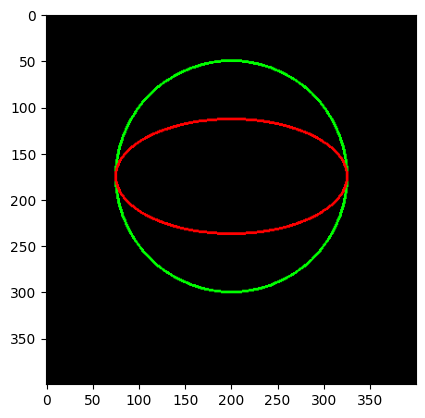

In [13]:
import cv2
import numpy as np


def drawCircleEllipseOnImgFromTwoPoints(point1, point2):
    # Calculate the center of the circle/ellipse
    center_x = (point1[0] + point2[0]) // 2
    center_y = (point1[1] + point2[1]) // 2
    center = (center_x, center_y)
    
    # Calculate the radius of the circle
    radius = int(np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2) / 2)
    
    # Create a blank image
    image = np.zeros((400, 400, 3), dtype=np.uint8)
    
    # Draw the circle
    cv2.circle(image, center, radius, (0, 255, 0), 2)
    
    # To draw an ellipse, you need to define the axes and the angle
    # For simplicity, let's assume the major axis is the distance between the two points
    # and the minor axis is half of the major axis
    major_axis = int(np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2))
    minor_axis = major_axis // 2
    angle = 0  # Angle of the ellipse
    
    # Draw the ellipse
    cv2.ellipse(image, center, (major_axis // 2, minor_axis // 2), angle, 0, 360, (255, 0, 0), 2)
    
    # Display the image
    plt.imshow(image)

# Define the two points
point1 = (100, 100)
point2 = (300, 250)
drawCircleEllipseOnImgFromTwoPoints(point1, point2)

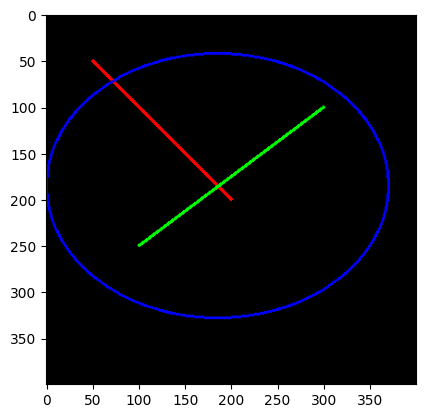

In [24]:
import cv2
import numpy as np

# Function to find the intersection of two line segments
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return int(x), int(y)

def drawEllipseByTwoIntersectionLineSegments(line1:list, line2:list):
   
    # Find the intersection point
    intersection = line_intersection(line1, line2)
    
    # Calculate distances from the intersection point to each of the four points
    distances = [
        np.sqrt((intersection[0] - line1[0][0])**2 + (intersection[1] - line1[0][1])**2),
        np.sqrt((intersection[0] - line1[1][0])**2 + (intersection[1] - line1[1][1])**2),
        np.sqrt((intersection[0] - line2[0][0])**2 + (intersection[1] - line2[0][1])**2),
        np.sqrt((intersection[0] - line2[1][0])**2 + (intersection[1] - line2[1][1])**2)
    ]
    
    # Determine the major and minor axes
    major_axis = max(distances)
    if distances.index(major_axis) <2:
        distances=distances[2:]
    else:
        distances=distances[:2]
    
    minor_axis = max(distances)
    
    # Create a blank image
    image_height, image_width = 400, 400
    image = np.zeros((image_height, image_width, 3), dtype=np.uint8)
    
    # Ensure the ellipse is within the image boundaries
    center_x, center_y = intersection
    major_axis = int(major_axis)
    minor_axis = int(minor_axis)
    
    # Adjust the center and axes if necessary
    if center_x - major_axis < 0:
        major_axis = center_x
    if center_x + major_axis >= image_width:
        major_axis = image_width - center_x - 1
    if center_y - minor_axis < 0:
        minor_axis = center_y
    if center_y + minor_axis >= image_height:
        minor_axis = image_height - center_y - 1
    
    # Draw the line segments
    cv2.line(image, line1[0], line1[1], (255, 0, 0), 2)
    cv2.line(image, line2[0], line2[1], (0, 255, 0), 2)
    
    # Draw the ellipse
    cv2.ellipse(image, intersection, (major_axis, minor_axis), 0, 0, 360, (0, 0, 255), 2)
    
    # Display the image
    plt.imshow(image)

# Define the two line segments
line1 = [(50, 50), (200, 200)]
line2 = [(100, 250), (300, 100)]
drawEllipseByTwoIntersectionLineSegments(line1, line2)

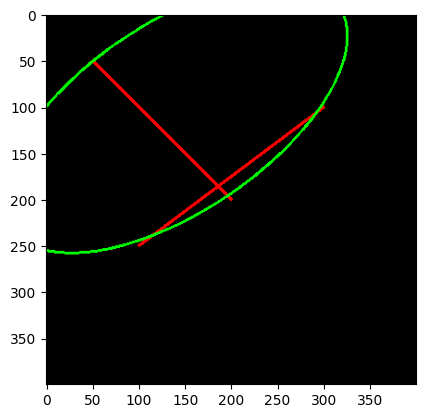

In [28]:
def find_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    # Calculate the determinant
    det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

    if det == 0:
        return None  # Lines are parallel or coincident

    # Calculate the intersection point
    px = ((x1*y2 - y1*x2) * (x3 - x4) - (x1 - x2) * (x3*y4 - y3*x4)) / det
    py = ((x1*y2 - y1*x2) * (y3 - y4) - (y1 - y2) * (x3*y4 - y3*x4)) / det

    return int(px), int(py)

def fit_ellipse_to_lines(line1, line2):
    intersection = find_intersection(line1, line2)
    if intersection is None:
        raise ValueError("Lines do not intersect")

    points = np.array([
        [line1[0], line1[1]],
        [line1[2], line1[3]],
        [line2[0], line2[1]],
        [line2[2], line2[3]],
        intersection
    ], dtype=np.float32)

    # Fit an ellipse to the points
    ellipse = cv2.fitEllipse(points)
    return ellipse

def draw_ellipse(image, ellipse):
    cv2.ellipse(image, ellipse, (0, 255, 0), 2)

def main():
    # Define the two intersecting line segments
    line1 = (50, 50, 200, 200)
    line2 = (200, 50, 50, 200)

    line1 =(50, 50, 200, 200)
    line2 = (100, 250, 300, 100)
    # Create a blank image
    image = np.zeros((400, 400, 3), dtype=np.uint8)

    # Draw the line segments
    cv2.line(image, (line1[0], line1[1]), (line1[2], line1[3]), (255, 0, 0), 2)
    cv2.line(image, (line2[0], line2[1]), (line2[2], line2[3]), (255, 0, 0), 2)

    # Fit an ellipse to the line segments
    ellipse = fit_ellipse_to_lines(line1, line2)

    # Draw the ellipse
    draw_ellipse(image, ellipse)

    # Display the image
    plt.imshow(image)

main()

In [57]:
import cv2
import numpy as np

# Create a blank image
image = np.zeros((500, 500, 3), dtype=np.uint8)

# Define the parameters of the rotated rectangle
center = (250.00087, 250)  # Center of the rectangle
size = (300, 200)     # Width and height of the rectangle
angle = 30            # Angle of rotation

# Calculate the axes of the ellipse
axes = (int(size[0] / 2), int(size[1] / 2))

# Draw the ellipse on the image
cv2.ellipse(image, center, axes, angle, 0, 360, (255, 255, 255), 1)

# Get the points that approximate the ellipse
ellipse_points = cv2.ellipse2Poly(center, axes, angle, 0, 360, 10)

# Convert the points to a polygon
polygon = np.array(ellipse_points, dtype=np.int32)
polygon = polygon.reshape((-1, 1, 2))

# Draw the polygon on the image
cv2.polylines(image, [polygon], isClosed=True, color=(0, 255, 0), thickness=1)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'ellipse'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - ellipse() takes at most 5 arguments (8 given)
>  - ellipse() takes at most 5 arguments (8 given)


In [61]:
# Example tuple with float items
float_tuple = (16.5, 2.7, 3.9, 4.2)

# Define a lambda function to convert float to int
convert_to_int = lambda x: int(x)

# Use the lambda function with map to convert the tuple
int_tuple = tuple(map(convert_to_int, float_tuple))

print(int_tuple)  # Output: (1, 2, 3, 4)


(16, 2, 3, 4)


In [62]:
funA = lambda float_tuple: tuple(map(convert_to_int, float_tuple))
print(f"2: {funA(float_tuple)}")

2: (16, 2, 3, 4)


In [63]:
funB = lambda float_tuple: tuple(map(int, float_tuple))
print(f"2: {funB(float_tuple)}")

2: (16, 2, 3, 4)


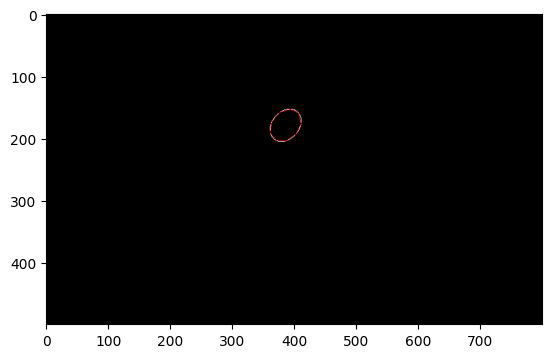

In [97]:
import cv2
import numpy as np
### ellipse=((386.61578369140625, 179.8028106689453), (44.276954650878906, 58.850643157958984), 40.876983642578125)
# Create a blank image
image = np.zeros((500, 800, 3), dtype=np.uint8)

# Define the parameters of the rotated rectangle
center = (386.61578369140625, 179.8028106689453) #(250, 250)  # Center of the rectangle
size =  (44.276954650878906, 58.850643157958984)#(300, 200)     # Width and height of the rectangle
angle = 40.876983642578125           # Angle of rotation

funB = lambda float_tuple: tuple(map(int, float_tuple))
center = funB(center)
size = funB(size)
angle = int(angle)
# Calculate the axes of the ellipse
axes = (int(size[0] / 2), int(size[1] / 2))

# Draw the ellipse on the image
cv2.ellipse(image,center, axes, angle, 0, 360, (255, 255, 255), 1)

# Get the points that approximate the ellipse
ellipse_points = cv2.ellipse2Poly(center, axes, angle, 0, 360, 40)

# Convert the points to a polygon
#polygon = np.array(ellipse_points, dtype=np.int32)
polygon = ellipse_points
#polygon = polygon.reshape((-1, 1, 2))

# Draw the polygon on the image
cv2.polylines(image, [polygon], isClosed=True, color=(255, 2, 0), thickness=1)

plt.imshow(image)

In [111]:
import numpy as np

# Example np.ndarray with shape (13, 2)
array = np.array([[1.1, 2.2], [3.3, 4.4], [5.5, 6.6], [7.7, 8.8], [9.9, 10.10],
                  [11.11, 12.12], [13.13, 14.14], [15.15, 16.16], [17.17, 18.18],
                  [19.19, 20.20], [21.21, 22.22], [23.23, 24.24], [25.25, 26.26]])

# Convert the ndarray to a list of tuples
list_of_tuples = [tuple(row) for row in array.tolist()]

print(list_of_tuples)
# Convert the list of tuples to a ndarray
array3 = np.array(list_of_tuples)


print(array3.shape, array3) 

[(1.1, 2.2), (3.3, 4.4), (5.5, 6.6), (7.7, 8.8), (9.9, 10.1), (11.11, 12.12), (13.13, 14.14), (15.15, 16.16), (17.17, 18.18), (19.19, 20.2), (21.21, 22.22), (23.23, 24.24), (25.25, 26.26)]
(13, 2) [[ 1.1   2.2 ]
 [ 3.3   4.4 ]
 [ 5.5   6.6 ]
 [ 7.7   8.8 ]
 [ 9.9  10.1 ]
 [11.11 12.12]
 [13.13 14.14]
 [15.15 16.16]
 [17.17 18.18]
 [19.19 20.2 ]
 [21.21 22.22]
 [23.23 24.24]
 [25.25 26.26]]


In [4]:
import pathlib

casesstr=r"/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/"

casespath=pathlib.Path(casesstr)
casefolders = casespath.iterdir()
for icase in casefolders:
    print(f"{icase}, stem={icase.stem}")

/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401010411.01, stem=02.202401010411
/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401031368.01, stem=02.202401031368
/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401031860.01, stem=02.202401031860
/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401050559.01, stem=02.202401050559
/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401051410.01, stem=02.202401051410
/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401090031.03, stem=02.202401090031
/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241216-staticPACS_censoredOut/censor_out_pre/02.202401121499.01, stem=02.202401121499
/mnt/f/241129-zhipu-thyroid-datas/

In [8]:
str("301PACSddd").startswith("301PACS")

True

In [28]:
import shutil

ss=r"/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/241223-301pacsDataInlbmfmt"
casespath=pathlib.Path(ss)
casefolders = casespath.iterdir()

names=[]
for icase in casefolders:
    name00=icase.name
    names.append(name00)
print(f"items = {len(names)}")

dog=0
cnt=0
casefolders = casespath.iterdir()
for icase in casefolders:
    name0=icase.name
    #print(f"dog{dog}: {name0}")
    if ".0" not in name0:
        print(f"dog{dog}: {name0}")
        for iname in names:
            if iname.startswith(name0) and iname != name0:
                cnt +=1
                print(f"{cnt}>delete: {name0}-{icase}")
                shutil.move(icase, pathlib.Path(r"/mnt/f/241129-zhipu-thyroid-datas/10-received-datas/duplicates"))
    dog+=1
    if dog>10000:
        break
                


items = 1047
dog0: 301PACS02-2401010285
dog1: 301PACS02-2401010320
dog9: 301PACS02-2401021712
dog16: 301PACS02-2401032136
dog17: 301PACS02-2401040150
dog24: 301PACS02-2401050123
dog26: 301PACS02-2401050526
dog28: 301PACS02-2401051387
dog34: 301PACS02-2401060066
dog35: 301PACS02-2401060090
dog36: 301PACS02-2401060126
dog38: 301PACS02-2401080470
dog39: 301PACS02-2401081067
dog43: 301PACS02-2401081780
dog44: 301PACS02-2401081934
dog47: 301PACS02-2401090110
dog48: 301PACS02-2401090371
dog49: 301PACS02-2401090654
dog50: 301PACS02-2401091034
dog52: 301PACS02-2401091110
dog56: 301PACS02-2401092331
dog57: 301PACS02-2401092332
dog58: 301PACS02-2401100158
dog59: 301PACS02-2401100232
dog64: 301PACS02-2401102125
dog67: 301PACS02-2401110250
dog69: 301PACS02-2401110638
dog70: 301PACS02-2401110754
dog74: 301PACS02-2401120492
dog75: 301PACS02-2401120772
dog76: 301PACS02-2401120990
dog77: 301PACS02-2401121156
dog80: 301PACS02-2401121627
dog83: 301PACS02-2401130128
dog90: 301PACS02-2401151504
dog93: 301